# Angaza Decision Scientist - "Homework" Responses

## Briefly document any observations about the data made during initial exploration / investigation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew as skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
import scorecardpy as sc

#First, let's load the dataset

file_path = "/Users/Alex/Desktop/hw_table.csv"
df = pd.read_csv(file_path)

#And let's run some basic summary statistics first
summary_stats = df.describe()
summary_stats

,default_flag,var2,var3,var8,var9,var10,var12,var13,var14,var15,...,var33,var34,var35,var36,var37,var39,var40,var42,var43,loanid
count,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,...,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000
mean,0.189394,11.461039,64.599567,10.178571,147.873377,94.737554,4.816017,11.904762,514.778139,744.949134,...,77.079004,66.666126,116.417208,10393.765693,16.540043,12622.769481,3112.847787,0.359848,30.600649,924.500000
std,0.391927,1.851439,32.333064,22.104260,9.753107,18.276403,20.146156,30.720417,134.011569,4441.903284,...,131.645848,112.110673,179.275081,17335.360952,17.260027,21459.086786,6940.037951,0.480086,9.435079,533.615967
min,0.000000,1.000000,0.000000,0.000000,15.000000,25.000000,0.000000,0.000000,180.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,1.000000
25%,0.000000,12.000000,40.000000,0.000000,150.000000,100.000000,0.000000,0.000000,410.000000,0.000000,...,16.000000,15.000000,9.000000,2000.000000,5.000000,1550.000000,0.000000,0.000000,24.000000,462.750000
50%,0.000000,12.000000,60.000000,0.000000,150.000000,100.000000,0.000000,0.000000,560.000000,0.000000,...,35.000000,30.000000,48.000000,5000.000000,12.000000,4880.000000,217.410000,0.000000,28.000000,924.500000
75%,0.000000,12.000000,80.000000,10.000000,150.000000,100.000000,0.000000,0.000000,600.000000,0.000000,...,75.000000,70.000000,145.000000,10500.000000,22.000000,12000.000000,4244.180000,1.000000,35.250000,1386.250000
max,1.000000,24.000000,160.000000,100.000000,150.000000,100.000000,100.000000,100.000000,840.000000,86286.000000,...,1257.000000,1050.000000,1905.000000,150000.000000,215.000000,150000.000000,139188.000000,1.000000,73.000000,1848.000000


Some basic stats: there are 1848 observations, and the mean for "default_flag" is 0.1894, meaning 18.94% of the loans in the dataset were defaulted on.

Next, let's print the density function for each variable to get the shape of the data.

In [2]:
#Data cleaning steps

#We can encode the booleans as dummy variables. Let's check what's going on with the object variables:
df[['var38', 'var41']].head()

#These are timestamps. Let's get both of these datatypes coded as integers/floats.
df.loc[:, df.select_dtypes(include=bool).columns] = df.select_dtypes(include=bool).astype(int)
                    
# Convert object timestamps to datetime
df.loc[:, df.select_dtypes(include=object).columns] = df.select_dtypes(include=object).apply(pd.to_datetime).astype(int)

/var/folders/8l/ql1hnshs7k585mkb6w6pzrzw0000gn/T/ipykernel_88475/3435916974.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, df.select_dtypes(include=object).columns] = df.select_dtypes(include=object).apply(pd.to_datetime).astype(int)


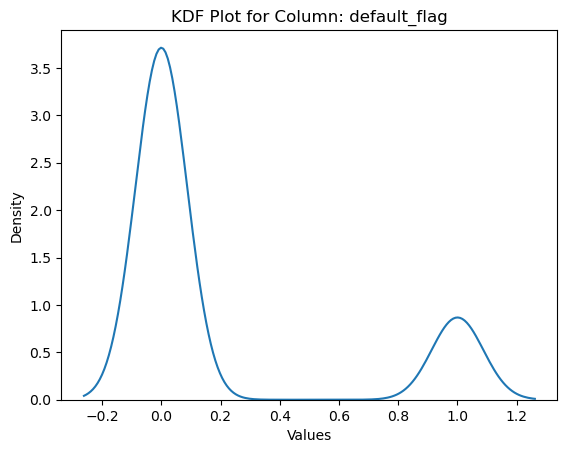

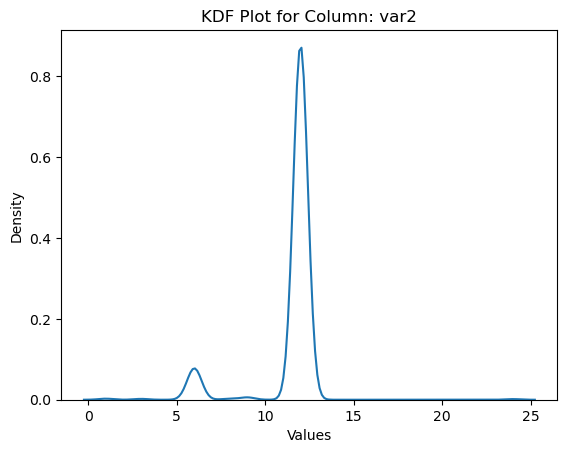

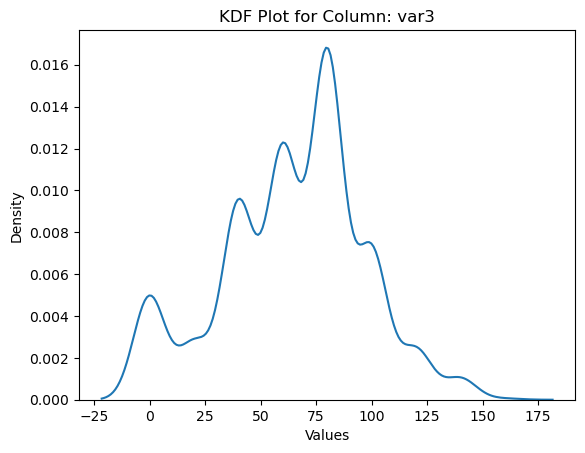

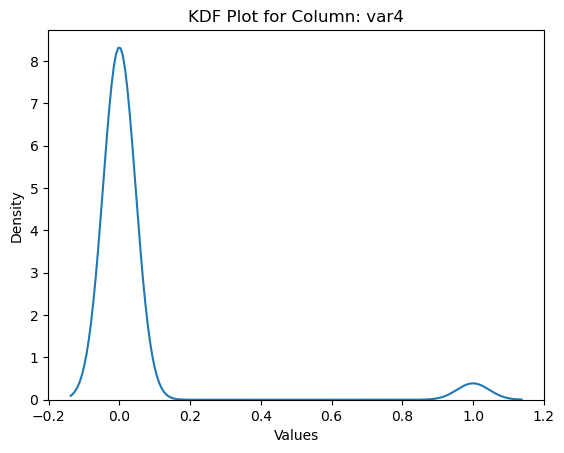

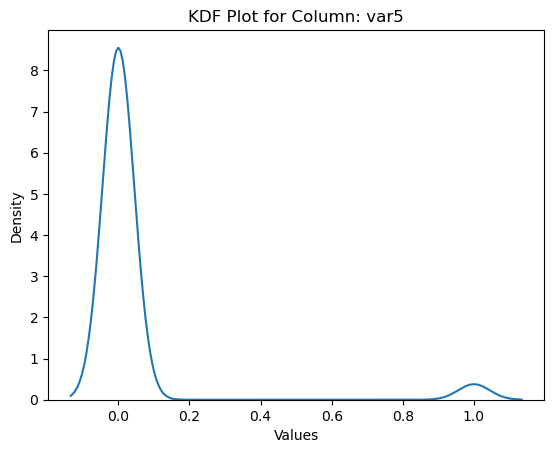

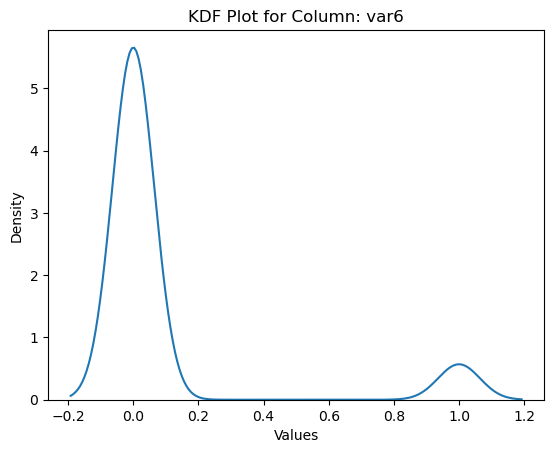

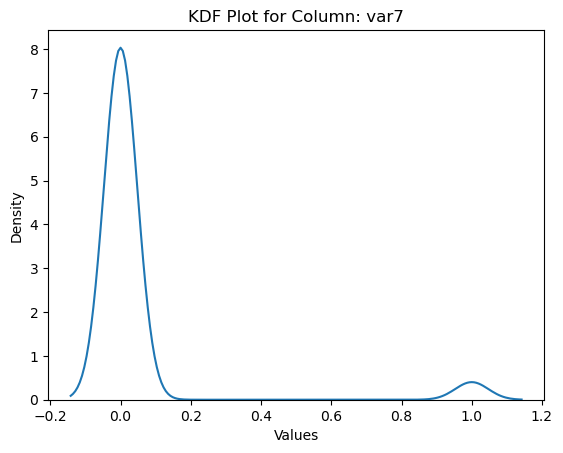

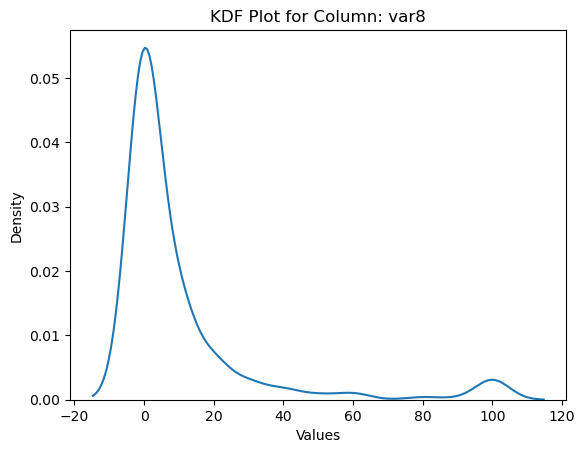

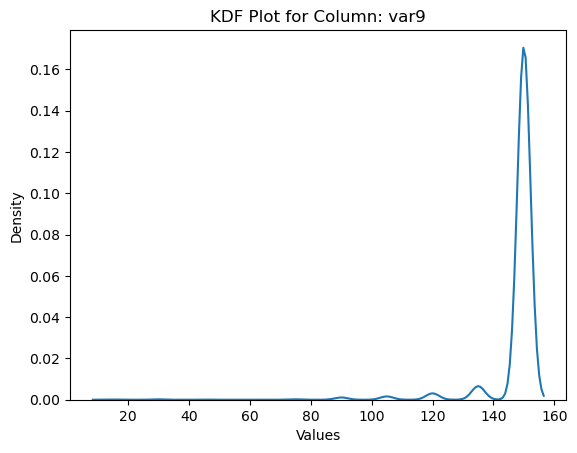

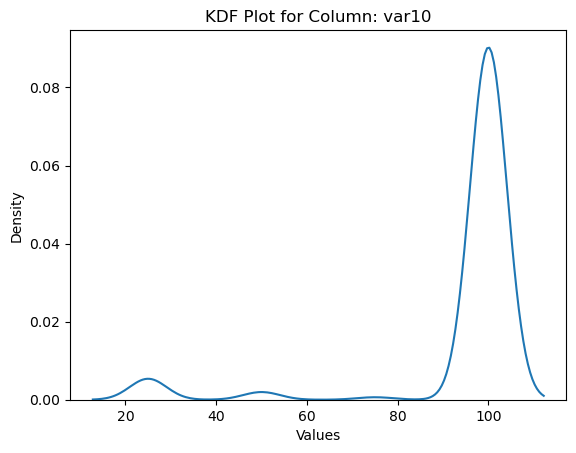

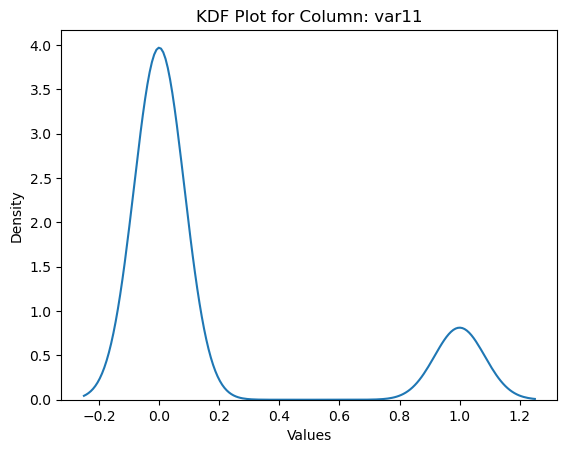

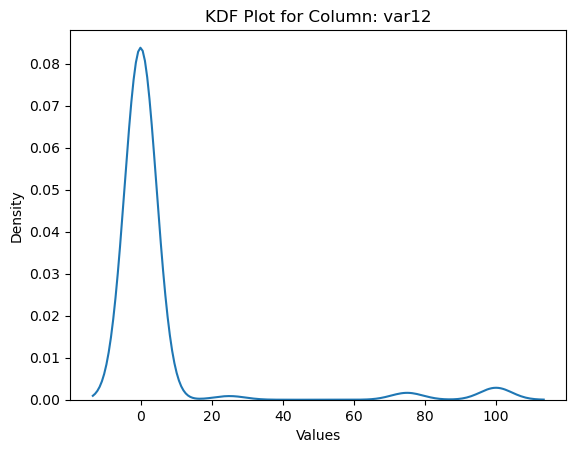

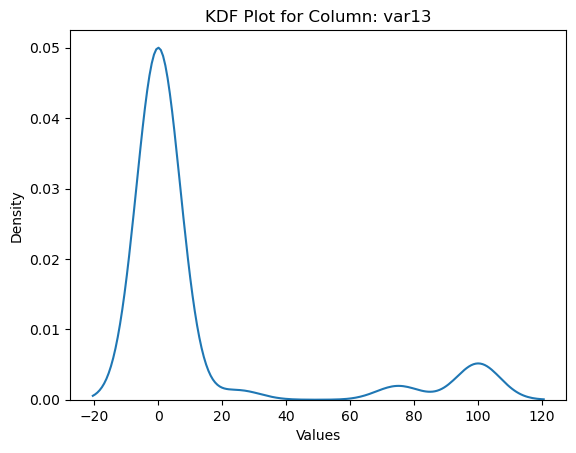

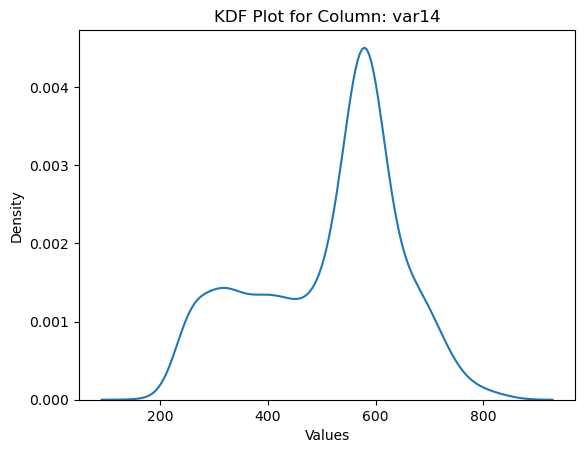

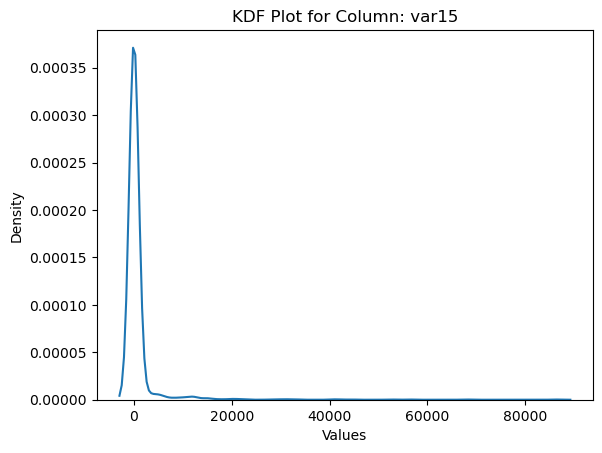

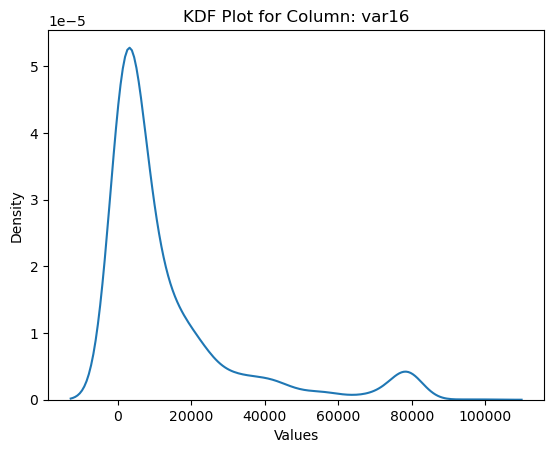

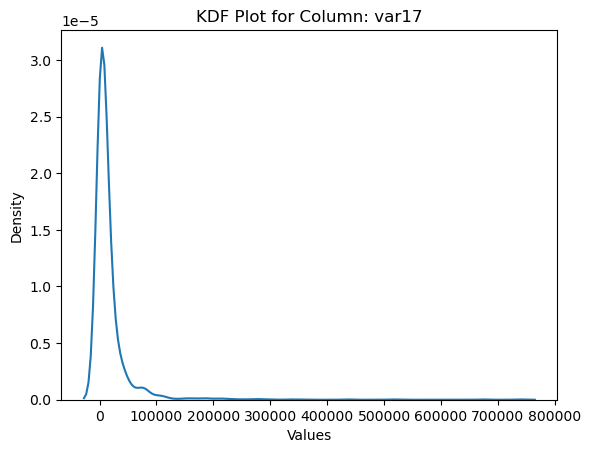

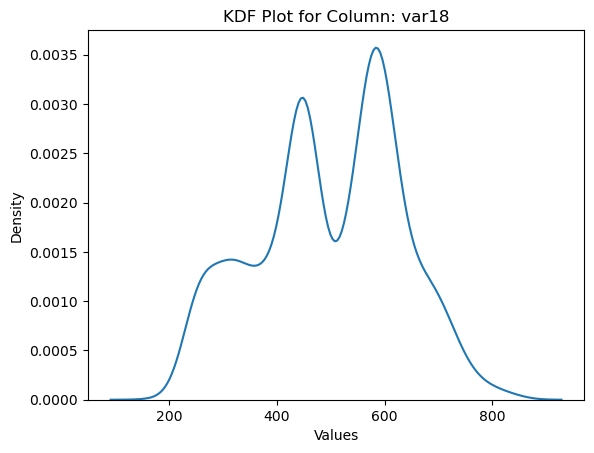

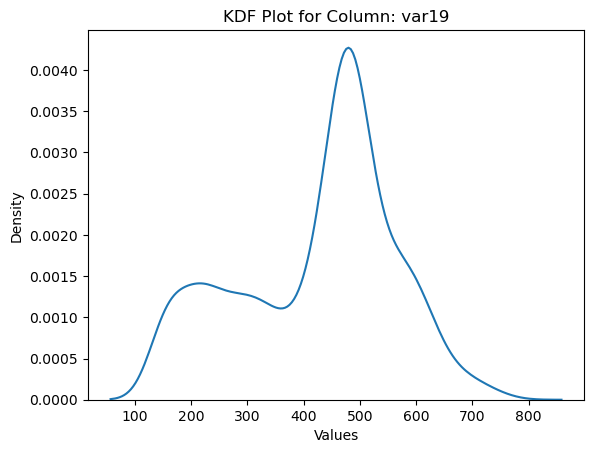

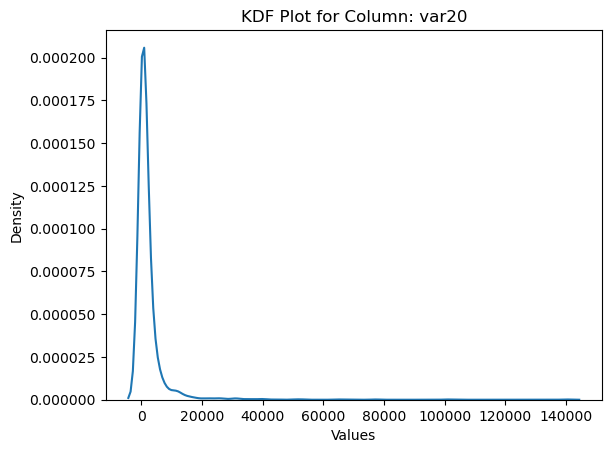

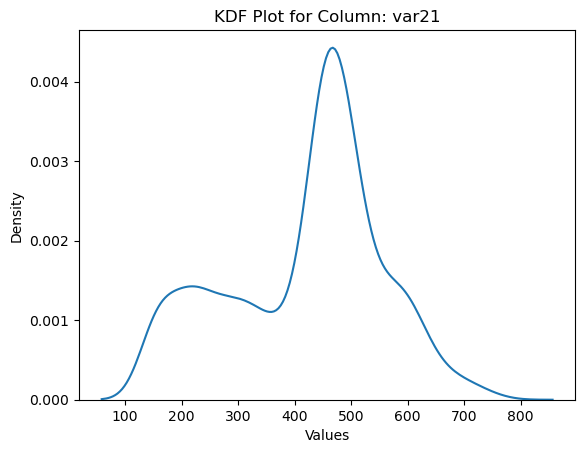

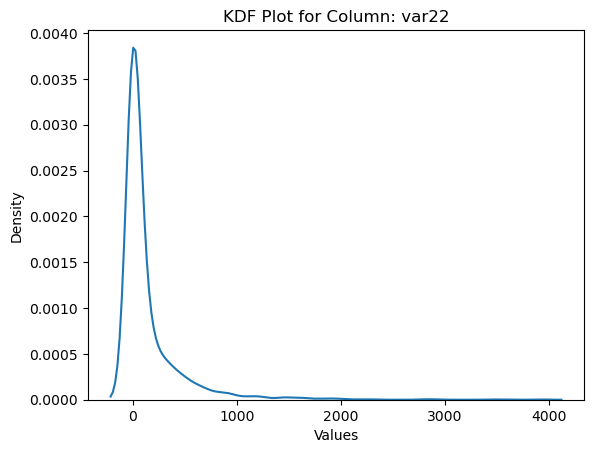

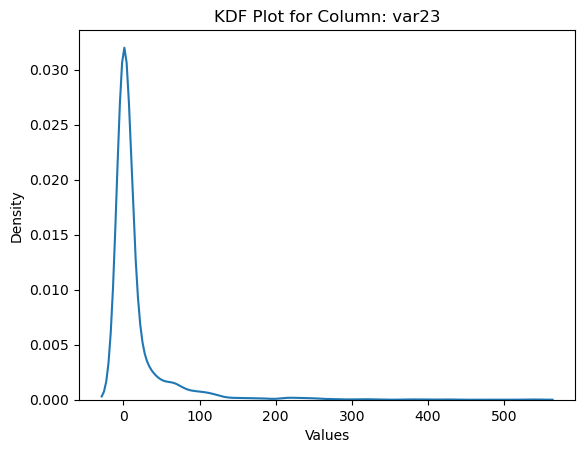

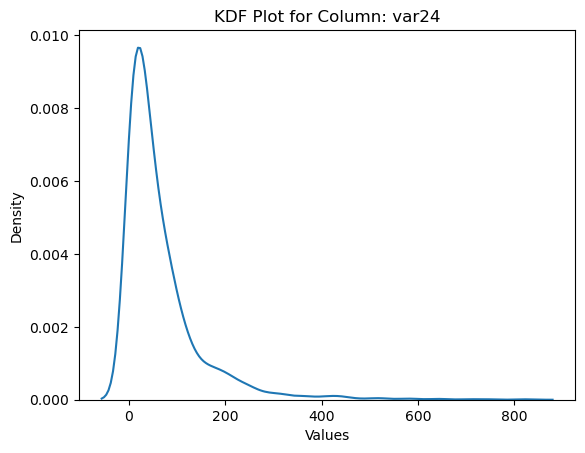

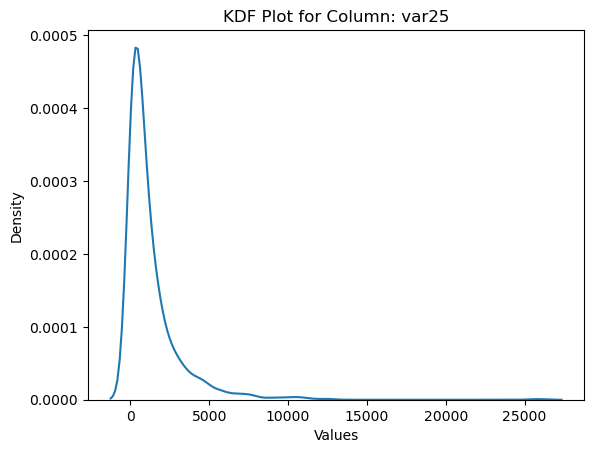

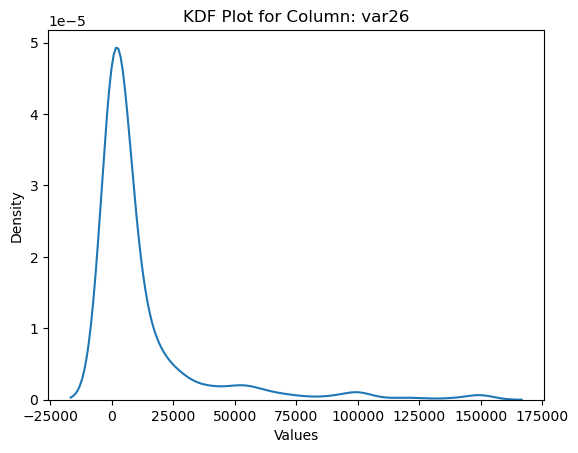

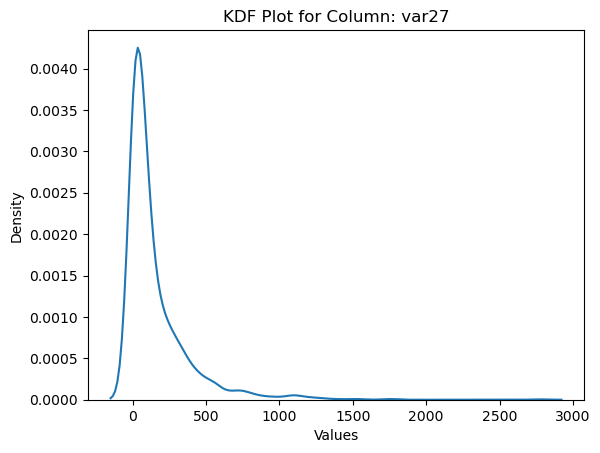

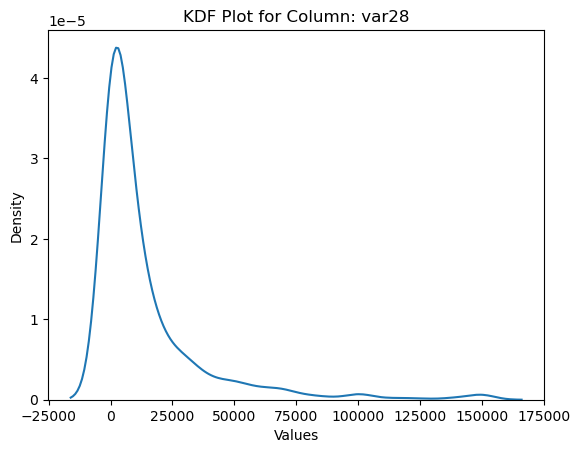

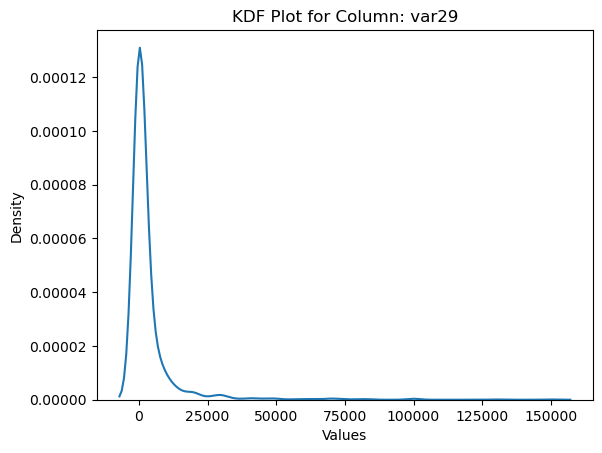

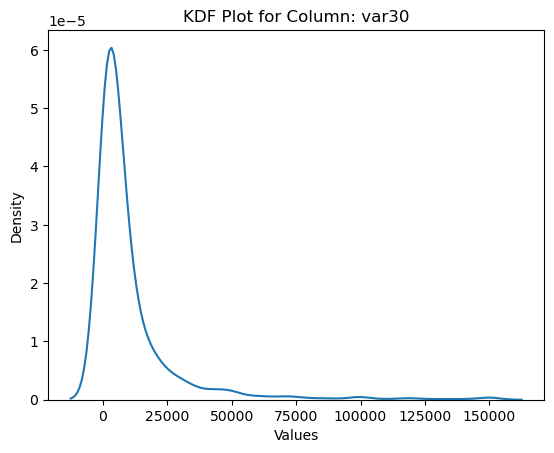

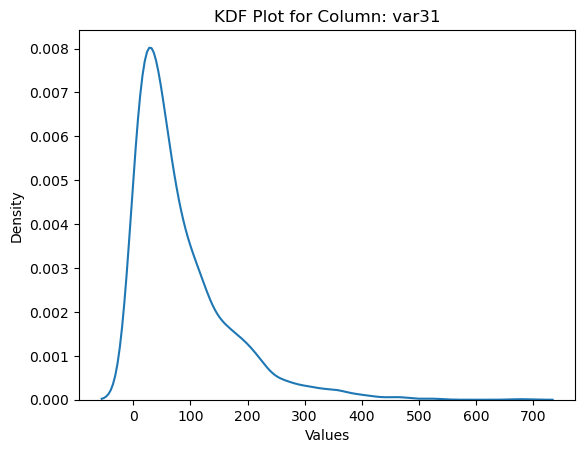

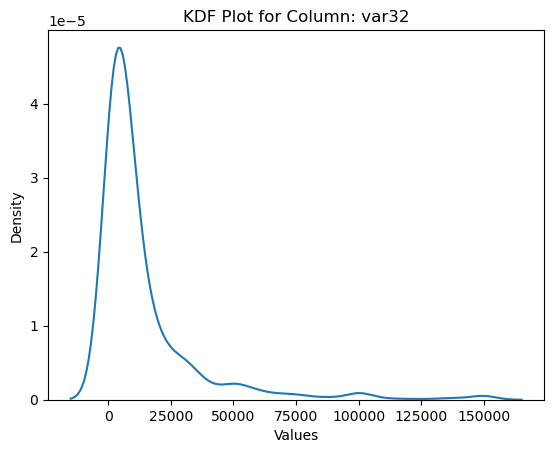

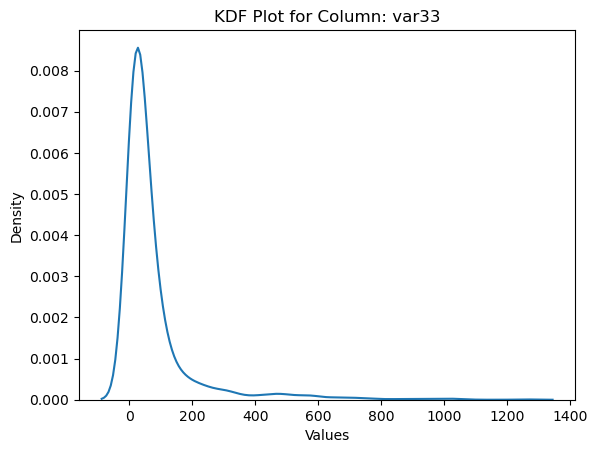

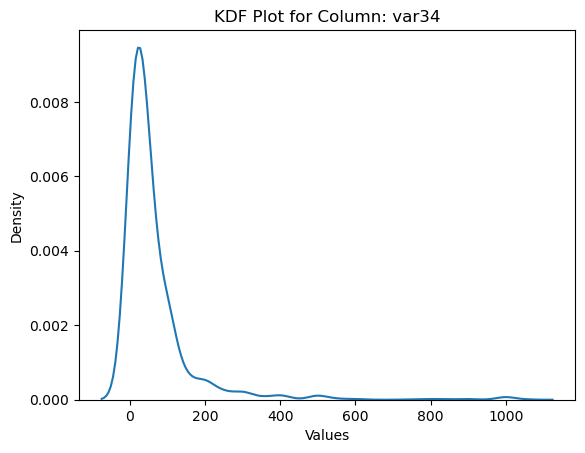

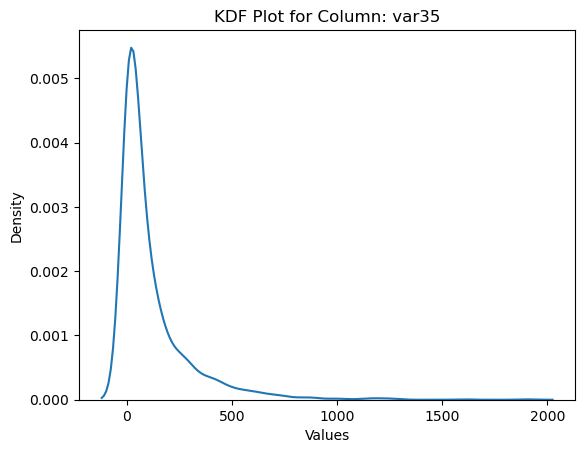

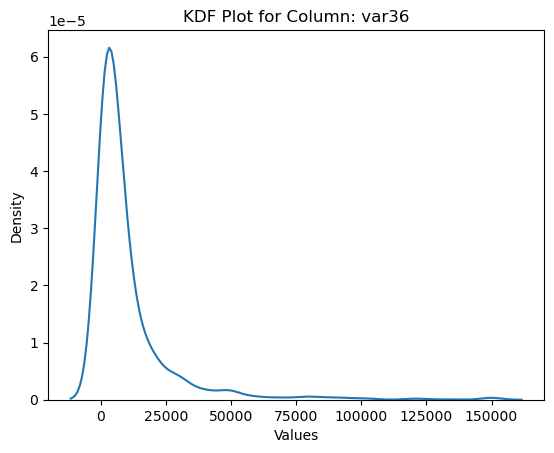

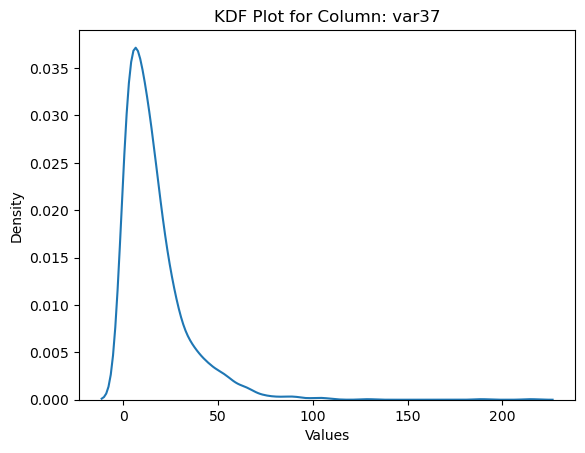

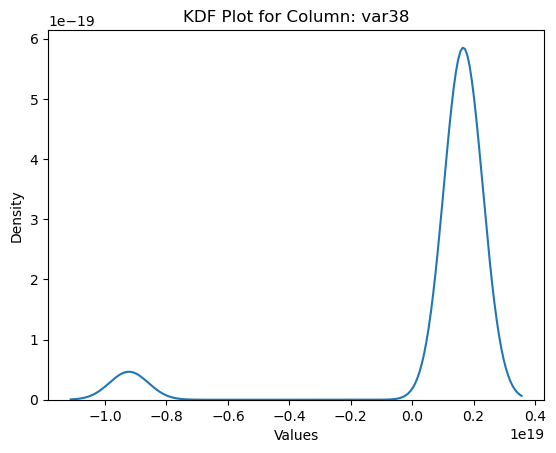

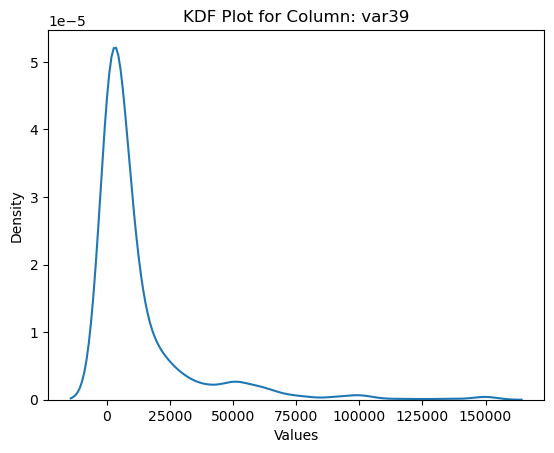

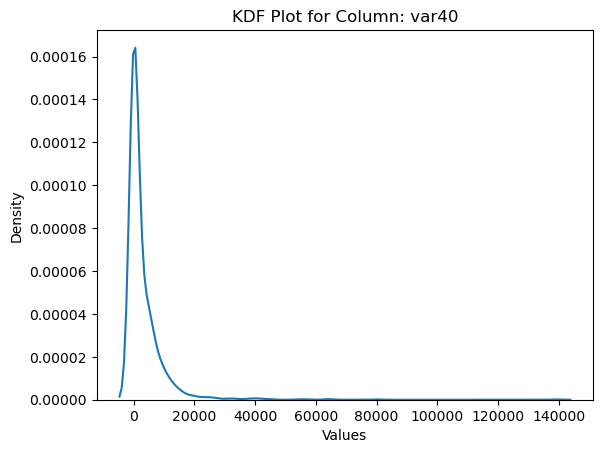

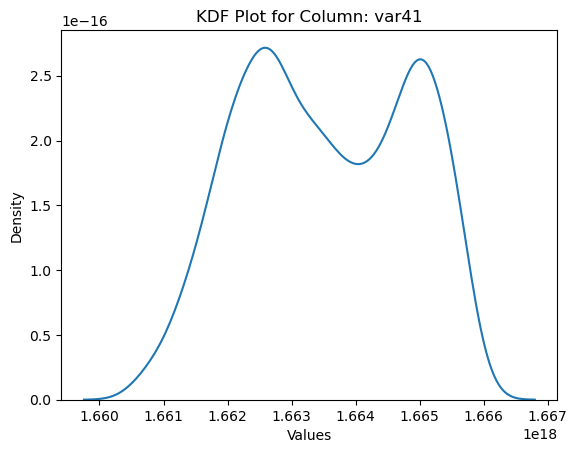

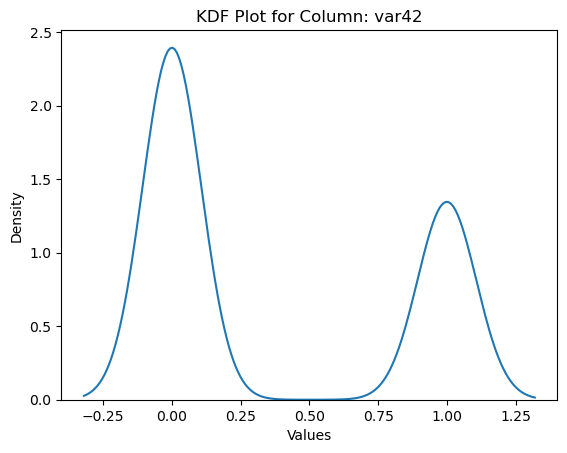

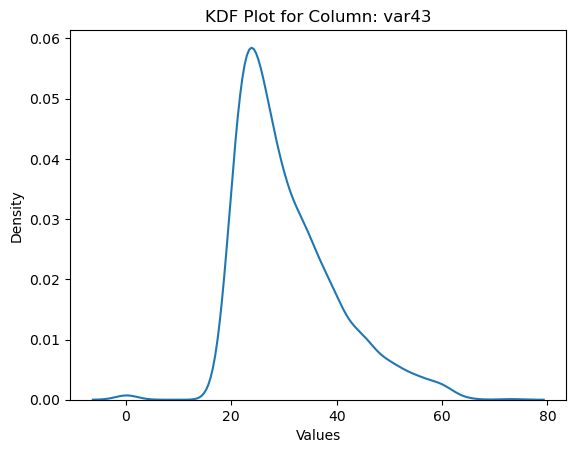

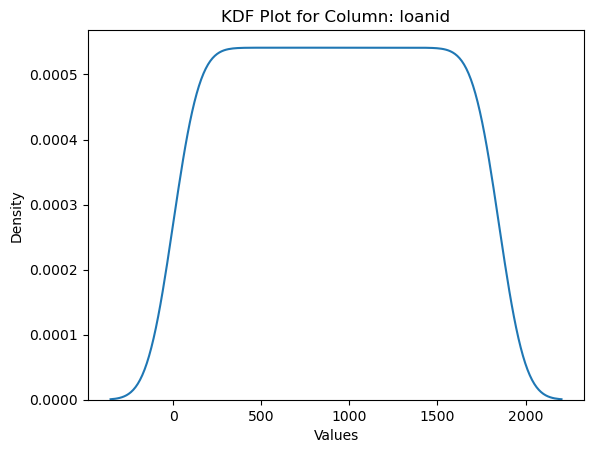

In [3]:
# Plot KDF for each column
for column in df.columns:
    # Create a new figure and axis for each column
    fig, ax = plt.subplots()

    # Plot the KDF for the current column
    sns.kdeplot(df[column], ax=ax)

    # Set the title and labels for the subplot
    ax.set_title(f'KDF Plot for Column: {column}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')

    # Show the KDF plot for the current column
    plt.show()

### A few observations

* There are quite a few right-skewed variables with a median/mode around 0 and a long right tail - around half the variables in the dataset.
* Much of the data appears to have been recorded in regular increments; for example, the values in var10 are either 0, 25, 50, 75, 100. These might be transformed into categorical data in the future.
* The two timestamp columns have very different distributions. Upon review, "var38" has quite a bit of missing data. 

Next, let's transform the dataset so that the datatypes are all numerical. Then we can check for outliers.

### Addressing data quality in var38:

One of the issues is that var38 has many missing values. This is one of two timestamp fields in the dataset.

Complicating matters is the fact that many of the columns seem to take on values of 0 whereas rows that have the timestamp usually have positive non-zero values. This suggests that the data in these rows is incomplete but it is hard to know how that will affect the model.

What I will do to handle this in the model is:
* Find the mean difference between var41 (the other timestamp column) and var38 for all the values that are correctly reflecting in both, and use that to estimate what the missing var38 value should be.
* Create a new value var38_na_flag which is a dummy variable to indicate which rows had var38 imputed in this way.


In [4]:
# Create a variable var38_na_flag
df['var38_na_flag'] = np.where(df['var38'] <= 0, 1, 0)

# Calculate the mean difference between var41 and var38
mean_diff = df.loc[df['var38_na_flag'] == 0, 'var41'].mean() - df.loc[df['var38_na_flag'] == 0, 'var38'].mean()

# Update var38 for rows where var38_na_flag = 1
df.loc[df['var38_na_flag'] == 1, 'var38'] = df.loc[df['var38_na_flag'] == 1, 'var41'] - mean_diff

# Print the updated DataFrame
df.head()

,default_flag,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var36,var37,var38,var39,var40,var41,var42,var43,loanid,var38_na_flag
0,1,12,60,0,0,0,0,0,150,100,...,1550,15,1661804258000000000,420,0.00,1662021289000000000,0,24,1,0
1,0,12,60,0,0,1,0,0,150,100,...,4500,6,1662924989000000000,4400,74.87,1663404707000000000,0,23,2,0
2,0,12,120,0,0,0,0,60,135,25,...,30400,61,1661529247000000000,22000,12966.26,1661525421000000000,1,49,3,0
3,1,12,80,0,0,0,0,20,150,100,...,2000,8,1664397353000000000,5050,29.00,1664542621000000000,0,22,4,0
4,0,12,80,0,0,0,0,10,150,100,...,5000,4,1663001409000000000,4000,0.00,1663402816000000000,0,24,5,0


Now let's do a visual inspection of the density functions to confirm the change:

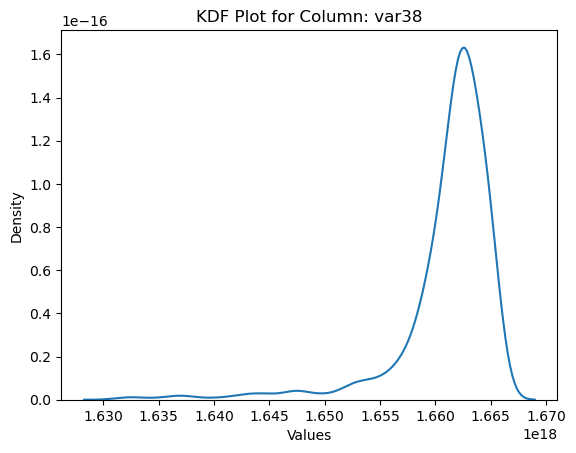

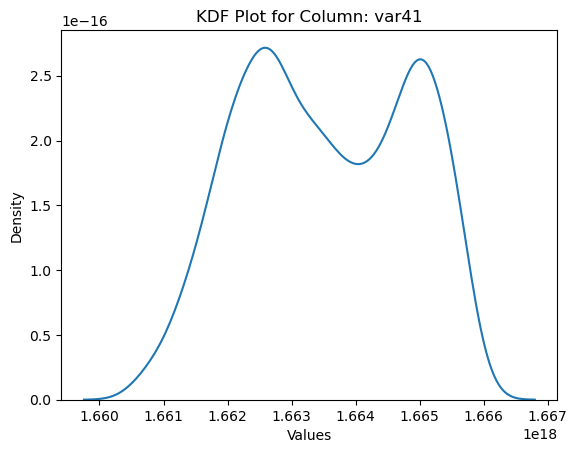

In [5]:
for column in df[['var38', 'var41']]:
    # Create a new figure and axis for each column
    fig, ax = plt.subplots()

    # Plot the KDF for the current column
    sns.kdeplot(df[column], ax=ax)

    # Set the title and labels for the subplot
    ax.set_title(f'KDF Plot for Column: {column}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')

    # Show the KDF plot for the current column
    plt.show()
    
    # Looks good!

### Checking for outliers

Below I use the interquartile range method to check for outliers:

In [6]:
# Calculate interquartile range (IQR)
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
IQR = Q3 - Q1

# Determine outliers using IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outlier values
outliers = (df < lower_bound) | (df > upper_bound)

# Identify columns with outliers
columns_with_outliers = outliers.columns[outliers.any()]

# Create a new DataFrame with only columns containing outliers
filtered_data = df[columns_with_outliers]

# Display the filtered DataFrame
filtered_data.describe()

/var/folders/8l/ql1hnshs7k585mkb6w6pzrzw0000gn/T/ipykernel_88475/22931767.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = (df < lower_bound) | (df > upper_bound)


,default_flag,var10,var12,var13,var15,var16,var17,var2,var20,var22,...,var33,var34,var35,var36,var37,var39,var40,var43,var8,var9
count,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,...,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000
mean,0.189394,94.737554,4.816017,11.904762,744.949134,13318.344156,16644.967532,11.461039,2283.712121,145.148810,...,77.079004,66.666126,116.417208,10393.765693,16.540043,12622.769481,3112.847787,30.600649,10.178571,147.873377
std,0.391927,18.276403,20.146156,30.720417,4441.903284,19169.196891,41221.622506,1.851439,6410.248281,319.301125,...,131.645848,112.110673,179.275081,17335.360952,17.260027,21459.086786,6940.037951,9.435079,22.104260,9.753107
min,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,15.000000
25%,0.000000,100.000000,0.000000,0.000000,0.000000,1900.000000,1900.000000,12.000000,200.000000,0.000000,...,16.000000,15.000000,9.000000,2000.000000,5.000000,1550.000000,0.000000,24.000000,0.000000,150.000000
50%,0.000000,100.000000,0.000000,0.000000,0.000000,5300.000000,5300.000000,12.000000,700.000000,5.000000,...,35.000000,30.000000,48.000000,5000.000000,12.000000,4880.000000,217.410000,28.000000,0.000000,150.000000
75%,0.000000,100.000000,0.000000,0.000000,0.000000,15725.000000,15725.000000,12.000000,2000.000000,147.250000,...,75.000000,70.000000,145.000000,10500.000000,22.000000,12000.000000,4244.180000,35.250000,10.000000,150.000000
max,1.000000,100.000000,100.000000,100.000000,86286.000000,97100.000000,737400.000000,24.000000,140100.000000,3909.000000,...,1257.000000,1050.000000,1905.000000,150000.000000,215.000000,150000.000000,139188.000000,73.000000,100.000000,150.000000


### Analyzing the variables with outlier flags

In dealing with outlier variables, we can remove outliers or transform the data to improve the performance of our model.

In reviewing the outlier variables, there are a few cases here:
* Right skewed data with a long right tail: in this case most of the observations are clustered around 0, with a long tail of positive values. If the tail is long enough (range is large, but IQR is small) this is indicative of some outliers.

* Uneven bimodal or multimodal distributions: some of the boolean/dummy variables are very unevenly weighted, which results in them being flagged as outliers if there are relatively few True values.

# Which 7 features do you find to be the most predictive? Taking into consideration any multicollinearity (correlation amongst independent variables / features). Briefly explain your approach.

First, let me explain my approach to data cleaning, which I will perform first before trying to build a predictive model:

* I have taken the log of all the skewed variables to normalize the data and reduce outliers
* I test if there are still outliers by looking at the interquartile range
* If so, I use RobustScaler to normalize the data; otherwise, I use StandardScaler

In [7]:
# You cannot take the logarithm of a negative, so I address that first.

# Filter DataFrame to show rows with negative values
negative_rows = df[(df < 0).any(axis=1)]
negative_rows.head()

# Here you can see there is only one negative value in column var40

,default_flag,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var36,var37,var38,var39,var40,var41,var42,var43,loanid,var38_na_flag
1499,1,1,20,0,0,1,0,0,150,100,...,0,0,1662646824152453632,0,-19.0,1665156295000000000,0,19,1500,1


In [8]:
# Update the filtered values to 0
df[df < 0] = 0

In [9]:
# Performing the other transformations:

# Define the column to exclude
exclude_column = 'loanid'

# Define the skewness threshold
skewness_threshold = 1

# Initialize empty dictionary for scaled columns
scaled_columns = {}

# Loop through each column in the DataFrame
for column in df.columns:
    if column != exclude_column:
        # Step 1: Test if the column is a dummy variable
        if df[column].isin([0, 1]).all():
            # Do nothing for dummy variables
            scaled_column = df[column]
            scaled_column_name = column
        else:
            # Step 2: Test for skew and transform skewed variables using np.log1p
            if df[column].skew() > skewness_threshold:
                transformed_column = np.log1p(df[column])
                transformed_column_name = f'{column}_log'
            else:
                transformed_column = df[column]
                transformed_column_name = column
            # Step 3: Test if the column has outliers and scale accordingly
            if np.percentile(transformed_column, 75) - np.percentile(transformed_column, 25) > 1.5 * (np.percentile(transformed_column, 75) - np.percentile(transformed_column, 25)):
                scaler = RobustScaler()
                scaled_column = scaler.fit_transform(transformed_column.values.reshape(-1, 1))
                scaled_column_name = f'{transformed_column_name}_robust'
            else:
                scaler = StandardScaler()
                scaled_column = scaler.fit_transform(transformed_column.values.reshape(-1, 1))
                scaled_column_name = f'{transformed_column_name}_standard'
                
        scaled_columns[scaled_column_name] = scaled_column.squeeze()

# Create a new DataFrame with the scaled columns
df_scaled = pd.DataFrame(scaled_columns)

df_scaled.to_csv('df_scaled.csv', index=False)